<a href="https://colab.research.google.com/github/bhashithadeshara/Brain-tumor-Identification-System/blob/ensembleModel/new_ensembled_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [2]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import imgaug.augmenters as iaa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import os

<ipython-input-4-76a77fef43af>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [5]:
X_train = []
Y_train = []
image_size = 224
labels = ['glioma','meningioma','notumor','pituitary']
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MSC/Msc Project/DataSet/brain_tumour/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MSC/Msc Project/DataSet/brain_tumour/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

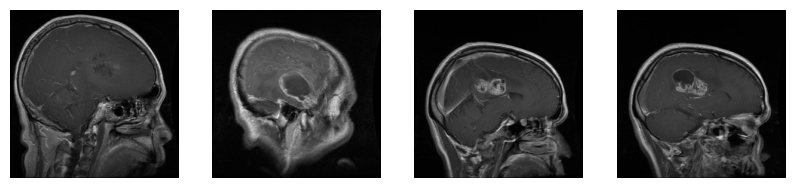

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()

In [7]:
# Define data augmentation sequence
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    iaa.Flipud(0.5),  # vertically flip 50% of the images
    iaa.GaussianBlur(sigma=(0.0, 3.0)),  # apply gaussian blur with sigma ranging from 0 to 3
    iaa.Affine(rotate=(-45, 45)),  # rotate images randomly between -45 to 45 degrees
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # add gaussian noise
    iaa.Multiply((0.8, 1.2)),  # change brightness of images
    iaa.LinearContrast((0.75, 1.5)),  # improve or worsen the contrast
    iaa.Crop(percent=(0, 0.1)),  # crop images from each side by 0 to 10%
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent (per axis)
    ),
    iaa.PerspectiveTransform(scale=(0.01, 0.1))  # apply a perspective transform
])

# Function to apply data augmentation to images
def augment_images(images):
    augmented_images = augmentation(images=images)
    return augmented_images

In [8]:
# Function to apply data augmentation to images
def augment_images(images):
    augmented_images = augmentation(images=images)
    return augmented_images

X_train_augmented = []
Y_train_augmented = []

# Apply data augmentation to training images
for i, label in enumerate(Y_train):
    img = X_train[i]
    X_train_augmented.append(img)
    Y_train_augmented.append(label)

    # Augment the image and label
    augmented_img = augment_images([img])[0]
    X_train_augmented.append(augmented_img)
    Y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)

In [ ]:
X_train_augmented,Y_train_augmented = shuffle(X_train_augmented,Y_train_augmented,random_state=101)
X_train_augmented.shape

(14046, 224, 224, 3)

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_train_augmented,Y_train_augmented,test_size=0.1,random_state=101)
X_train.shape

(12641, 224, 224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)


Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (8469, 224, 224, 3)
X_test Shape:  (4172, 224, 224, 3)
y_train Shape:  (8469, 4)
y_test Shape:  (4172, 4)


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D True
11 MaxPooling2D True
12 Conv2D True
13 Conv2D True
14 Conv2D True
15 Conv2D True
16 MaxPooling2D True
17 Conv2D True
18 Conv2D True
19 Conv2D True
20 Conv2D True
21 MaxPooling2D True


In [ ]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model
    from keras.models import Sequential

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

In [ ]:
num_classes = 4

FC_Head = lw(vgg, num_classes)

model_vgg16 = Model(inputs = vgg.input, outputs = FC_Head)

print(model_vgg16.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)  # Adjust learning rate as needed
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

history = model_vgg16.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    initial_epoch=0
)

Epoch 1/100
265/265 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.4089
Epoch 1: val_loss improved from inf to 2.64630, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


265/265 [==============================] - 121s 389ms/step - loss: 1.4595 - accuracy: 0.4089 - val_loss: 2.6463 - val_accuracy: 0.4003
Epoch 2/100
265/265 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.4695
Epoch 2: val_loss improved from 2.64630 to 1.69126, saving model to best_model.h5
265/265 [==============================] - 93s 353ms/step - loss: 1.2645 - accuracy: 0.4695 - val_loss: 1.6913 - val_accuracy: 0.3555
Epoch 3/100
265/265 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.5389
Epoch 3: val_loss did not improve from 1.69126
265/265 [==============================] - 94s 354ms/step - loss: 1.0988 - accuracy: 0.5389 - val_loss: 1.9060 - val_accuracy: 0.3313
Epoch 4/100
265/265 [==============================] - ETA: 0s - loss: 1.0100 - accuracy: 0.5704
Epoch 4: val_loss improved from 1.69126 to 1.39469, saving model to best_model.h5
265/265 [==============================] - 94s 353ms/step - loss: 1.0100 - accuracy: 0.5704 - v

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


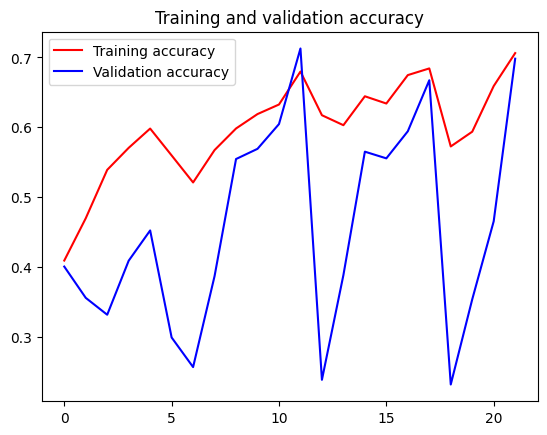

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
img = cv2.imread('/content/drive/MyDrive/MSC/Msc Project/DataSet/brain_tumour/Testing/pituitary/Te-pi_0011.jpg')
img = cv2.resize(img,(224, 224))
img_array = np.array(img)
img_array.shape



(224, 224, 3)

In [ ]:
img_array = img_array.reshape(1,224, 224,3)
img_array.shape

a=model_vgg16.predict(img_array)
indices = a.argmax()
indices

1/1 [==============================] - 1s 1s/step


3

In [ ]:
loss,acc = model_vgg16.evaluate(X_test,y_test)

131/131 [==============================] - 20s 152ms/step - loss: 3.4855 - accuracy: 0.6982


In [ ]:
print("Number of original training samples:", len(X_train))

Number of original training samples: 8469


In [ ]:
#training resnet model
from keras.applications import resnet50

# Load the ResNet50 model
resnet = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of ResNet50
# for layer in resnet.layers:
#     layer.trainable = False

94765736/94765736 [==============================] - 4s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D True
11 BatchNormalization True
12 Activation True
13 Conv2D True
14 Conv2D True
15 BatchNormalization True
16 BatchNormalization True
17 Add True
18 Activation True
19 Conv2D True
20 BatchNormalization True
21 Activation True
22 Conv2D True
23 BatchNormalization True
24 Activation True
25 Conv2D True
26 BatchNormalization True
27 Add True
28 Activation True
29 Conv2D True
30 BatchNormalization True
31 Activation True
32 Conv2D True
33 BatchNormalization True
34 Activation True
35 Conv2D True
36 BatchNormalization True
37 Add True
38 Activation True
39 Conv2D True
40 BatchNormalization True
41 Activation True
42 Conv2D True
43 BatchNormalization True
44 Activation True
45 Conv2D True
46 Conv2D True
47 BatchNor

In [ ]:
# Freeze the first 10 layers
for layer in resnet.layers[:10]:
    layer.trainable = False

# Unfreeze the rest of the layers
for layer in resnet.layers[10:]:
    layer.trainable = True

# Print the trainable layers
for (i, layer) in enumerate(resnet.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [ ]:
# Define the new head for the model
FC_Head = lw(resnet, num_classes)

# Create the new model
model_resnet = Model(inputs=resnet.input, outputs=FC_Head)

print(model_resnet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_resnet.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
265/265 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.7452
Epoch 1: val_loss improved from 0.69026 to 0.39776, saving model to best_model.h5
265/265 [==============================] - 134s 380ms/step - loss: 0.6835 - accuracy: 0.7452 - val_loss: 0.3978 - val_accuracy: 0.8528
Epoch 2/100
265/265 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8903
Epoch 2: val_loss improved from 0.39776 to 0.26782, saving model to best_model.h5
265/265 [==============================] - 93s 351ms/step - loss: 0.3134 - accuracy: 0.8903 - val_loss: 0.2678 - val_accuracy: 0.9156
Epoch 3/100
265/265 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9319
Epoch 3: val_loss improved from 0.26782 to 0.20076, saving model to best_model.h5
265/265 [==============================] - 93s 351ms/step - loss: 0.2026 - accuracy: 0.9319 - val_loss: 0.2008 - val_accuracy: 0.9343
Epoch 4/100
265/265 [==============================] - ETA: 

In [ ]:
loss,acc = model_resnet.evaluate(X_test,y_test)

In [ ]:
from keras.applications import efficientnet

# Load the EfficientNetB0 model
efficientnet = efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of EfficientNetB0
# for layer in efficientnet.layers:
#     layer.trainable = False

In [ ]:
# Freeze the first 10 layers
for layer in efficientnet.layers[:10]:
    layer.trainable = False

# Unfreeze the rest of the layers
for layer in efficientnet.layers[10:]:
    layer.trainable = True

# Print the trainable layers
for (i, layer) in enumerate(efficientnet.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [ ]:
# Define the new head for the model
FC_Head = lw(efficientnet, num_classes)

# Create the new model
model_efficientnet = Model(inputs=efficientnet.input, outputs=FC_Head)

print(model_efficientnet.summary())

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_efficientnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model_efficientnet.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
loss,acc = model_efficientnet.evaluate(X_test,y_test)

In [ ]:
a=model_efficientnet.predict(img_array)
indices = a.argmax()
indices

In [ ]:
from keras.applications import inception_v3

# Load the InceptionV3 model
inception = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of InceptionV3
# for layer in inception.layers:
#     layer.trainable = False

# Freeze the first 10 layers
for layer in inception.layers[:10]:
    layer.trainable = False

# Unfreeze the rest of the layers
for layer in inception.layers[10:]:
    layer.trainable = True

# Print the trainable layers
for (i, layer) in enumerate(inception.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

# Define the new head for the model
FC_Head = lw(inception, num_classes)

# Create the new model
model_inception = Model(inputs=inception.input, outputs=FC_Head)

print(model_inception.summary())

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_inception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_inception.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
loss,acc = model_inception.evaluate(X_test,y_test)

131/131 [==============================] - 9s 65ms/step - loss: 0.2747 - accuracy: 0.9233
